In [145]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
import plotly.graph_objects as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
import os
import plotly.offline

In [146]:
np.random.seed(12345)

In [147]:
# Download the latest SO dataset here: https://drive.google.com/open?id=1QOmVDpd8hcVYqqUXDXf68UMDWQZP0wQV
data_2019 = pd.read_csv("developer_survey_2019/survey_results_public.csv", low_memory=False)

In [148]:
to_drop = ["Respondent", "OpenSource", "CareerSat", "JobSat", "JobSeek", "ResumeUpdate", "SurveyLength", "SurveyEase",
           "WelcomeChange", "EntTeams", "ScreenName", "LastIn", "SO", "BlockchainIs", "BlockchainOrg", "WorkChallenge", "BetterLife", "OffOn", "Currency",
           "CompTotal", "CompFreq", "MainBranch", "PlatformDesireNextYear", "LanguageDesireNextYear", "DatabaseDesireNextYear", 
           "MiscTechDesireNextYear", "WebFrameDesireNextYear", "MgrMoney", "ITperson", "Age1stCode", "MgrIdiot", "MgrWant", "LastHireDate", 
           "Containers", "WorkLoc", "SONewContent"]

In [149]:
to_keep = ['Hobbyist', 'OpenSourcer', 'Employment', 'Country', 'Student', 'EdLevel', 'UndergradMajor', 'EduOther', 'OrgSize',
           'DevType', 'YearsCode', 'YearsCodePro', 'FizzBuzz', 'JobFactors', 'CurrencySymbol', 'CurrencyDesc',
           'ConvertedComp', 'WorkWeekHrs', 'WorkPlan', 'WorkRemote', 'ImpSyn', 'CodeRevHrs', 'UnitTests',
           'PurchaseHow', 'PurchaseWhat', 'LanguageWorkedWith', 'DatabaseWorkedWith', 'PlatformWorkedWith', 'WebFrameWorkedWith',
           'MiscTechWorkedWith', 'DevEnviron', 'OpSys', 'SocialMedia', 'Extraversion', 'Age', 'Gender', 'Trans', 'Sexuality', 
           'Ethnicity', 'Dependents']

In [150]:
# TODO: Rename columns
# TODO: Rename responses

In [151]:
def col_drop(df: pd.DataFrame, to_drop: list) -> pd.DataFrame:

    df_dropped = df.copy()

    for flag in to_drop:
        try:
            df_dropped.drop([x for x in df_dropped.columns if flag == x], axis=1, inplace=True)
        except:
            pass

    return df_dropped

In [152]:
def string_replace(s: str) -> int:
    try:
        s = float(s)
    except:
        s = -1000

    return s

In [153]:
def text_clean(text: str) -> str:
    text = str(text).replace(" ", "_").replace("-", "_").replace(
        ",", "_").replace(".", "").replace("+", "p").replace("#", "s").replace(
            "/", "_").replace("'", "").replace("ʼ", "").replace(
                "(", "_").replace(")", "_").replace("’", "").replace(
                    "__", "_").replace("__", "_").replace("“", "").replace(
                        "”", "").replace(":", "_").replace("&", "_").lower()

    banned = ["participated_in_", "_or", "_of", "_etc", "_employees", "taken_", 
              "_african_descent", "employed_", "developer_", "specialist_",
              "_european_descent"]

    for t in banned: text = text.replace(t, "")

    return text

In [154]:
def create_controls(df: pd.DataFrame, exclude: str) -> dict:

    controls = {}

    for col in df.columns:
        if col != exclude:
            controls[col] = {
                "omitted": text_clean(pd.Series([x for sub in list(
                           data_2019[col]
                           .apply(text_clean)
                           .apply(lambda x: str(x).split(";"))) for x in sub])
                           .value_counts()
                           .idxmax()), 
                "controls": list(set([x for sub in list(
                            data_2019[col]
                            .apply(text_clean)
                            .apply(lambda x: str(x).split(";"))) for x in sub]))}

    return controls

In [155]:
def design_matrix(df: pd.DataFrame, controls: dict) -> pd.DataFrame:
    dm = df.copy()
    
    for control in controls.keys():
        dm[control] = dm[control].apply(text_clean)

        if control in num_columns:
            for c in controls[control]["controls"]:
                dm[control+"_"+c] = (dm[control] == c) * 1

        else:
            for c in controls[control]["controls"]:
                dm[control+"_"+c] = dm[control].apply(lambda x: c in str(x).split(";")) * 1

        dm.drop(control, axis=1, inplace=True)
        dm.drop(control+"_"+controls[control]["omitted"], axis=1, inplace=True)

    dm = dm[sorted(dm.columns)]

    return dm

In [156]:
# Only consider those with income between $10,000 and $250,000
data_2019 = data_2019[(data_2019["ConvertedComp"] >= 10000) & (data_2019["ConvertedComp"] <= 250000)]
data_2019["ConvertedComp"] = np.log(data_2019["ConvertedComp"])

# Only consider US respondents
data_2019 = data_2019[data_2019["Country"] == "United States"]
#data_2019.drop(["Country"], axis=1, inplace=True)

# Only consider 18+ respondents
data_2019 = data_2019[data_2019["Age"] >= 21]

# Only consider respondents in the workforce
data_2019 = data_2019[data_2019["Employment"] != "Retired"]
data_2019 = data_2019[data_2019["Employment"] != "Not employed, and not looking for work"]

data_2019 = data_2019[data_2019["WorkWeekHrs"] >= 5]

# No students
data_2019 = data_2019[["Student" not in str(x) for x in data_2019["DevType"].values]]
data_2019 = data_2019[data_2019["Student"] == "No"]

# Only consider those with at least some education
data_2019 = data_2019[data_2019["EdLevel"] != "I never completed any formal education"]

data_2019 = data_2019.fillna("no_answer")

num_columns = ["Age", "YearsCode", "YearsCodePro", "WorkWeekHrs", "CodeRevHrs"]

# Convert numeric columns to int
for col in num_columns:
    data_2019[col] = data_2019[col].astype("int32", errors="ignore")

data_2019["YearsCode"].replace("Less than 1 year", "0", inplace=True)
data_2019["YearsCode"].replace("More than 50 years", "51", inplace=True)

# Exclude respondents who selected multiple gender, race, or sexual orientation options
data_2019 = data_2019[~data_2019["Gender"].str.contains(";")]
data_2019 = data_2019[~data_2019["Ethnicity"].str.contains(";")]
data_2019 = data_2019[~data_2019["Sexuality"].str.contains(";")]

# Keep certain columns
data_2019 = data_2019[to_keep]

data_2019 = data_2019.rename(columns = {"ConvertedComp": "Income"})

for col in num_columns:
    data_2019[col] = data_2019[col].apply(string_replace)

# Reset index
data_2019 = data_2019.reset_index(drop=True)

In [157]:
num_labels = [
    ["no_answer", "21-25", "26-30", "31-35", "35-40", "41-45", "45-50", "51-55", "55-60", "61-65", "66-"],
    ["no_answer","00-05", "06-10", "11-15", "16-20", "21-25", "26-30", "31-35", "35-40", "41-"],
    ["no_answer","00-05", "06-10", "11-15", "16-20", "21-25", "26-30", "31-35", "35-40", "41-"],
    ["no_answer","00-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-"],
    ["no_answer","01-02", "02-04", "04-06", "06-08", "08-10", "11-15", "16-20", "21-"]
]

num_buckets = [
    np.array([-1001,0,25,30,35,40,45,50,55,60,65,100]),
    np.array([-1001,0,5,10,15,20,25,30,35,40,100]),
    np.array([-1001,0,5,10,15,20,25,30,35,40,100]),
    np.array([-1001,0,10,20,30,40,50,60,70,80,200]),
    np.array([-1001,0,2,4,6,8,10,15,20,200])
]

In [158]:
# Bucket numerical columns
for i, col in enumerate(num_columns):
    data_2019[col] = pd.cut(data_2019[col], 
                            num_buckets[i], 
                            labels=num_labels[i]).astype("str")

In [159]:
controls = create_controls(data_2019, "Income")

In [160]:
data_2019 = design_matrix(data_2019, controls)

In [161]:
est = sm.OLS(endog=data_2019["Income"].values, 
             exog=data_2019.drop("Income", axis=1).assign(const=1)).fit()

In [162]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     33.63
Date:                Mon, 10 Feb 2020   Prob (F-statistic):               0.00
Time:                        10:36:27   Log-Likelihood:                -2189.5
No. Observations:               10355   AIC:                             4985.
Df Residuals:                   10052   BIC:                             7180.
Df Model:                         302                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================================================================
                                                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_21_25                                                                                                        -0.1091      0.010    -10.589      0.000      -0.129      -0.089
Age_31_35                                                                                                         0.0458      0.010      4.712      0.000       0.027       0.065
Age_35_40                                                                                                         0.0259      0.012      2.104      0.035       0.002       0.050
Age_41_45                                                                                                         0.0319      0.016      1.938      0.053      -0.000       0.064
Age_45_50                                                                                                         0.0214      0.020      1.064      0.287      -0.018       0.061
Age_51_55                                                                                                        -0.0244      0.025     -0.996      0.319      -0.072       0.024
Age_55_60                                                                                                        -0.0177      0.030     -0.586      0.558      -0.077       0.041
Age_61_65                                                                                                        -0.0446      0.040     -1.110      0.267      -0.123       0.034
Age_66_                                                                                                          -0.0234      0.068     -0.342      0.732      -0.157       0.111
CodeRevHrs_02_04                                                                                                  0.0002      0.009      0.025      0.980      -0.017       0.018
CodeRevHrs_04_06                                                                                                  0.0150      0.009      1.592      0.111      -0.003       0.033
CodeRevHrs_06_08                                                                                                  0.0292      0.016      1.847      0.065      -0.002       0.060
CodeRevHrs_08_10                                                                                                  0.0047      0.016      0.295      0.768      -0.027       0.036
CodeRevHrs_11_15                                                                                                 -0.0136      0.024     -0.563      0.573      -0.061       0.034
CodeRevHrs_16_20                                         

In [163]:
def double_selection(df: pd.DataFrame, 
                     controls: dict, 
                     controls_adj: list, 
                     category: str) -> pd.DataFrame:
    """
    Runs double selection on dataframe for provided category, selecting relevant covariates
    
    Returns dataframe with important covariates along with original category
    """

    X = df[controls_adj].copy()

    W = df.drop(controls_adj, axis=1).assign(const=1).copy()

    W = W.drop("Income", axis=1)

    Y = df["Income"].copy()

    clf = LassoCV(cv=5, max_iter=10000, selection="random", n_jobs=-1)

    sfm = SelectFromModel(clf)

    for i, X_j in enumerate(X.columns):
        if i==0:
            A = sfm.fit(W, X[X_j]).get_support()
        else:
            A = A | sfm.fit(W, X[X_j]).get_support()

    B = sfm.fit(W, Y).get_support()
    
    """
    Code for square root lasso
    
    from scipy.stats import norm
    
    n = len(Y)
    p = W.shape[1]
    
    print(n, p)
    
    alpha = 1.1 * np.sqrt(n) * norm.ppf(1 - 0.05 / (2 * p))
    
    return sm.OLS(X["DevType_back_end"].astype(float), W.astype(float)).fit_regularized(method="sqrt_lasso", alpha=alpha).params
    
    """

    return pd.concat([W.T[A | B].T, X], axis=1)

In [164]:
def unlog(logged):
    """
    Unlogs logged quantities
    
    """
    return np.e**(logged) - 1

In [165]:
def output_graph(df: pd.DataFrame, 
                 controls: dict, 
                 lasso: bool=False, 
                 category: str=None,
                 online: bool=False) -> (pd.DataFrame, sm.regression.linear_model.RegressionResultsWrapper):
    """
    Runs double selection and plots chart of results coefficients along with unconditional pay gaps and respective confidence intervals
    
    """

    controls_adj = [category+"_"+control for control in controls[category]["controls"] if controls[category]["omitted"] != control]

    if lasso:
        exog = double_selection(df, controls, controls_adj, category).assign(const=1)
    else:
        exog = df.drop("Income", axis=1).assign(const=1)

    est_full = sm.OLS(endog=df["Income"], 
                      exog=exog).fit()
    
    est_simple = sm.OLS(endog=df["Income"], 
                        exog=df.drop("Income", 
                        axis=1)[controls_adj]
                        .assign(const=1)).fit()
    
    output_full = pd.concat([est_full.params, est_full.bse*1.96], 
                            axis=1).rename(columns={0: "coef_full", 1: "conf_95_full"}).filter(like=category+"_", axis=0)

    output_simple = pd.concat([est_simple.params, est_simple.bse*1.96], 
                              axis=1).rename(columns={0: "coef_simple", 1: "conf_95_simple"}).filter(like=category+"_", axis=0)
    
    output = pd.concat([output_full, output_simple], axis=1)

    output.index = [x.replace(category + "_", "") for x in output.index]

    if category in num_columns:
        output.sort_index(axis=0, 
                          ascending=True, 
                          inplace=True)
    else:
        output.sort_values(by="coef_full", 
                           ascending=False, 
                           inplace=True)

    if category == "OrgSize":
        output = output.T[['just_me_i_am_a_freelancer_sole_proprietor', '2_9', '10_to_19', '20_to_99', '100_to_499', 
                         '500_to_999', '1_000_to_4_999', '5_000_to_9_999', 'no_answer']].T
    
    output["explained"] = output["coef_simple"] - output["coef_full"]

    for x, y, z in zip(["upper_simple", "upper_full"], 
                       ["coef_simple", "coef_full"], 
                       ["conf_95_simple", "conf_95_full"]): output[x] = unlog(output[y] + output[z])

    for x, y, z in zip(["lower_simple", "lower_full"], 
                       ["coef_simple", "coef_full"], 
                       ["conf_95_simple", "conf_95_full"]): output[x] = unlog(output[y] - output[z])

    output["coef_simple"] = unlog(output["coef_simple"])
    output["coef_full"] = unlog(output["coef_full"])

    for x, y  in zip(["upper_simple", "upper_full"], 
                     ["coef_simple", "coef_full"]): output[x] = output[x] - output[y]

    for x, y  in zip(["lower_simple", "lower_full"], 
                     ["coef_simple", "coef_full"]): output[x] = output[y] - output[x]

    try: 
        output.drop(labels=["no_answer"], inplace=True)
    except:
        pass
    
    output_index = list(output.index)

    my_range=np.array(range(1,len(output_index)+1))

    output_index = [x[:16] for x in output.index]
    
    for i in range(0, len(output_index), 2):
       output_index[i] = "<br>" + output_index[i]

    fig = go.Figure(data=[
        go.Bar(name="Unadjusted", 
               x=my_range, 
               y=output["coef_simple"], 
               marker_color="#d7eaf7", 
               showlegend=False, 
               width=min(0.28, 0.28*len(my_range)/4), 
               hoverinfo="skip"),
        go.Bar(name="Adjusted", 
               x=my_range, 
               y=output["coef_full"], 
               marker_color="#ffcdcd",
               showlegend=False, 
               width=min(0.28, 0.28*len(my_range)/4), 
               hoverinfo="skip"),
        go.Scatter(name="Unadjusted", 
                   x=my_range-0.2, 
                   y=output["coef_simple"], 
                   mode="markers", 
                   marker_color="#3493d3", 
                   marker_size=20, 
                   error_y=dict(type="data", 
                                symmetric=False, 
                                array=output["upper_simple"], 
                                arrayminus=output["lower_simple"], 
                                width=5, 
                                thickness=2, 
                                visible=True),
                   hovertemplate="%{text}",
                   text=[name.replace("<br>", "") + 
                         ": {:+,.1%}".format(coef) + 
                         ", 95% conf: [{:+,.1%}".format(lower) + 
                         ", {:+,.1%}]".format(upper) for name, coef, upper, lower in zip(output_index, 
                                                                                        output["coef_simple"], 
                                                                                        output["coef_simple"] + output["upper_simple"], 
                                                                                        output["coef_simple"] - output["lower_simple"])]),
        go.Scatter(name="Adjusted", 
                   x=my_range+0.2, 
                   y=output["coef_full"], 
                   mode="markers", 
                   marker_color="red", 
                   marker_size=20,
                   error_y=dict(type="data", 
                                symmetric=False, 
                                array=output["upper_full"], 
                                arrayminus=output["lower_full"], 
                                width=5, 
                                thickness=2, 
                                visible=True),
                   hovertemplate="%{text}",
                   text=[name.replace("<br>", "") + 
                         ": {:+,.1%}".format(coef) + 
                         ", 95% conf: [{:+,.1%}".format(lower) + 
                         ", {:+,.1%}]".format(upper) for name, coef, upper, lower in zip(output_index, 
                                                                                        output["coef_full"], 
                                                                                        output["coef_full"] + output["upper_full"], 
                                                                                        output["coef_full"] - output["lower_full"])])],
                   layout=go.Layout(title=go.layout.Title(text=controls[category]["title"])))

    fig.update_layout(barmode="group", 
                      bargroupgap=0.1,
                      xaxis = dict(tickmode = "array",
                                   tickvals = my_range,
                                   ticktext = output_index,
                                   tickangle = 0,
                                   ticks = "outside",
                                   showline=True,
                                   linewidth=0.5,
                                   linecolor="black",
                                   range=[0.5, max(my_range)+0.5]),
                      yaxis = dict(tickformat = ".1%",
                                   ticks = "outside",
                                   title = "Pay Gap vs. " + controls[category]["omitted"][:16],
                                   showline=True,
                                   linewidth=0.5,
                                   linecolor="black",
                                   showgrid=True,
                                   gridcolor="#e8e8e8",
                                   gridwidth=0.5,
                                   zeroline=True,
                                   zerolinecolor="#e8e8e8",
                                   zerolinewidth=2),
                      #width=max(750, len(my_range) * 100),
                      margin = dict(r=0),
                      plot_bgcolor="white",
                      title_font = dict(size=20),
                      legend=go.layout.Legend(x=0,
                                              y=1,
                                              yanchor="bottom",
                                              orientation="h"))

    if not os.path.exists("images"):
        os.mkdir("images")
        
    if not os.path.exists("embeds"):
        os.mkdir("embeds")

    fig.write_image("images/" + category + ".jpg", scale=3)
    fig.write_html("embeds/" + category + ".html", include_plotlyjs='cdn')
    #print(plotly.offline.plot(fig, include_plotlyjs=False, output_type='div'))

    if online:
        py.plot(fig, filename=category)
    
    fig.show()
    
    return output, est_full

In [166]:
def prune_df(df: pd.DataFrame, category: str) -> pd.DataFrame:
    """
    Prunes dataframe columns to only include those with "category_" in the name
    
    Returns: Pruned dataframe
    """

    matching = [x for x in df.columns if category+"_" in x]

    return df[matching].copy()

In [167]:
def explain(df: pd.DataFrame, 
            regression, 
            controls: dict, 
            cat_to_explain: str, 
            coef_to_explain: str, 
            top: int = 5) -> (pd.DataFrame, float):
    """
    Decomposes explained portion of income gap between groups and returns top explainers

    Decomposition follows methodology of (Gelbach 2016)

    Returns: Dataframe with top 3 explainers and respective explained gaps
    """

    name = cat_to_explain + "_" + coef_to_explain

    df_copy = df.copy()

    X_1 = prune_df(df_copy, cat_to_explain).assign(const=1)

    explainers = [control for control in controls.keys() if control != cat_to_explain]

    results = pd.DataFrame()
    
    for i, explainer in enumerate(explainers):

        X_2 = prune_df(df_copy, explainer)

        X_2 = X_2.reindex(sorted(X_2.columns), axis=1)

        B_2 = regression.params.filter(like=explainer+"_").sort_index()

        X_2 = X_2[B_2.index]

        H_k = X_2.values @ B_2

        if i == 0:
            results = pd.DataFrame(sm.OLS(endog=H_k, exog=X_1).fit().params.rename(explainer))
        else:
            d = sm.OLS(endog=H_k, exog=X_1).fit().params.rename(explainer)

            results = results.join(d)

    neg = results.T.filter(items=[name]).sort_values(by=name)[name].sum() < 0

    results = results.T.filter(items=[name]).sort_values(by=name, ascending=neg)

    results.columns = [coef_to_explain]

    return results.iloc[:top].append(results.iloc[top:].sum().rename("Other")), regression.params.filter(items=[name]).values[0]

In [168]:
def output_waterfall(df: pd.DataFrame, 
                     coef_full: float, 
                     controls: dict, 
                     category: str,
                     exp: str,
                     online: bool=False) -> None:
    """
    Plots waterfall breakdown of explained pay gap 
    
    """

    coef_simple = coef_full + df.values.flatten().sum()

    step_names = ["Adjusted"] + list(df.index) + ["Unadjusted"]

    steps = np.array([coef_full] + list(df.values.flatten()) + [coef_simple])

    new_steps = [0] * len(steps)

    for step in range(len(steps)):
        if step == 0:
            new_steps[step] = unlog(steps[step])
        elif step == len(steps) - 1:
            new_steps[step] = unlog(coef_simple)
        else:
            new_steps[step] = unlog(sum(steps[:step+1])) - sum(new_steps[:step])

    steps = new_steps

    my_range=np.array(list(range(1, len(steps)+1)))

    for i in range(0, len(step_names), 2):
       step_names[i] = "<br>" + step_names[i]

    fig = go.Figure(go.Waterfall(orientation="v",
                                 measure=["absolute"] + (["relative"] * len(df.index)) + ["total"],
                                 x=step_names,
                                 text=["{:,.1%}".format(steps[0])] + 
                                      ["{:+,.1%}".format(step) for step in steps[1:-1]] + 
                                      ["{:,.1%}".format(steps[-1])],
                                 textposition="outside",
                                 y=steps,
                                 connector = {"line":{"color":"grey"}},
                                 hovertemplate="%{text}",
                                 name=df.columns[0],
                                 totals = {"marker":{"color":"#3493d3"}},
                                 decreasing = {"marker":{"color":"#ff4747"}}))

    fig.update_layout(title = "Drivers of the " + df.columns[0][:16] + " vs. " + controls[category]["omitted"][:16] + " pay gap", 
                      xaxis = dict(tickmode = "array",
                                   tickvals = step_names,
                                   tickangle = 0,
                                   ticks = "outside",
                                   showline=True,
                                   linewidth=0.5,
                                   linecolor="black"),
                      yaxis = dict(tickformat = ".1%",
                                   ticks = "outside",
                                   title = "Pay Gap vs. " + controls[category]["omitted"][:16],
                                   showline=True,
                                   linewidth=0.5,
                                   linecolor="black",
                                   showgrid=True,
                                   gridcolor="#e8e8e8",
                                   gridwidth=0.5,
                                   zeroline=True,
                                   zerolinecolor="#e8e8e8",
                                   zerolinewidth=2),
                      width=max(500, len(my_range) * 100),
                      margin=dict(r=0),
                      plot_bgcolor="white",
                      title_font = dict(size=20))

    if not os.path.exists("images"):
        os.mkdir("images")

    fig.write_image("images/" + category + "_" + exp + "_waterfall.jpg", scale=2)
    
    if online:
        py.plot(fig, filename=exp)

    fig.show()

In [169]:
def output_kde(df: pd.DataFrame, 
               category: str,
               exp: str,
               exp_list: list,
               online: bool=False) -> None:
    
    fig = ff.create_distplot([df[df[category] > -1][df[exp] == c][category] for c in exp_list], exp_list, bin_size=2, show_hist=True, show_rug=False)
    
    fig.update_layout(title = "Histogram: " + category,
                      xaxis = dict(tickangle = 0,
                                   ticks = "outside",
                                   showline=True,
                                   linewidth=0.5,
                                   linecolor="black"),
                      yaxis = dict(tickformat = ".1%",
                                   ticks = "outside",
                                   showline=True,
                                   linewidth=0.5,
                                   linecolor="black",
                                   showgrid=True,
                                   gridcolor="#e8e8e8",
                                   gridwidth=0.5,
                                   zeroline=True,
                                   zerolinecolor="#e8e8e8",
                                   zerolinewidth=2),
                      legend = go.layout.Legend(x=0,
                                              y=1,
                                              yanchor="bottom",
                                              orientation="h"),
                      margin=dict(r=0),
                      plot_bgcolor="white",
                      title_font = dict(size=20))
    
    if not os.path.exists("images"):
        os.mkdir("images")

    fig.write_image("images/" + category + "_" + exp + "_kde.jpg", scale=2)
    
    if online:
        py.plot(fig, filename=exp)
    
    fig.show()

In [170]:
titles = {"CodeRevHrs": "Income vs. 1-2 Hours of Code Review per Week",
          "Age": "Income vs. 26-30 Years of Age",
          "Ethnicity": "Income vs. White Developers",
          "Gender": "Income vs. Male Developers",
          "Sexuality": "Income vs. Straight / Heterosexual Developers",
          "Dependents": "Income vs. No Dependents"
}

In [171]:
for k in titles.keys():
    controls[k]["title"] = titles[k]

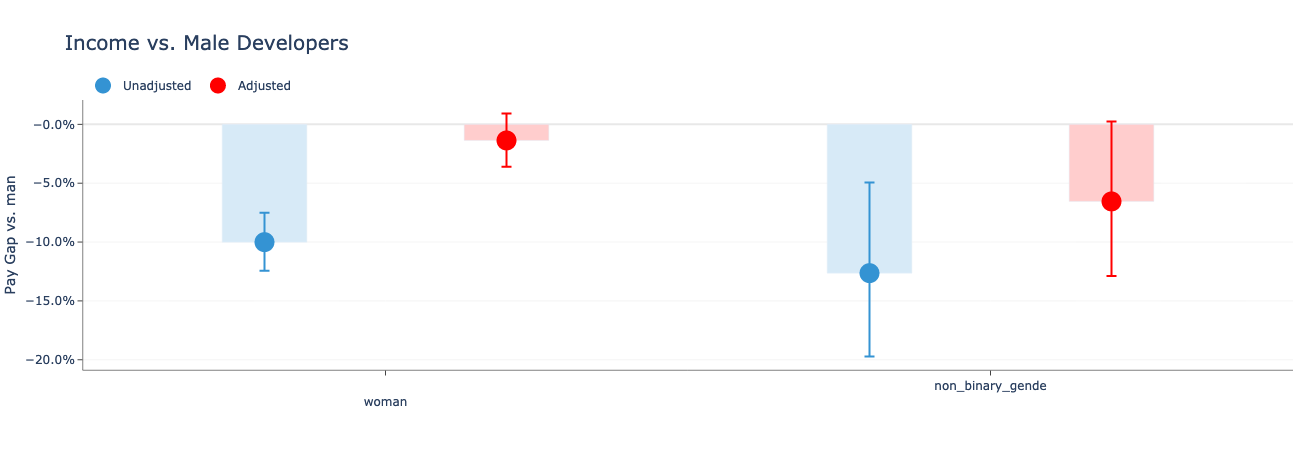

In [172]:
test, est = output_graph(data_2019, controls, True, "Gender", False)

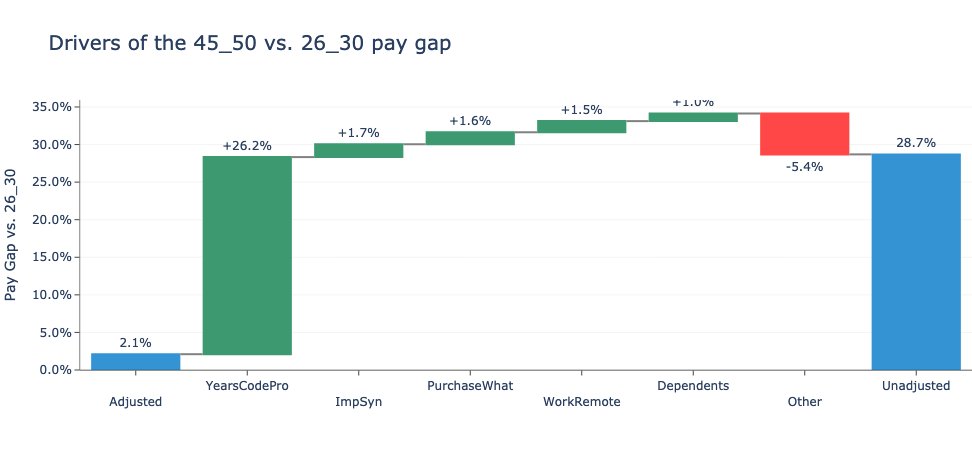

In [52]:
cat = "Gender"
exp = "non_binary_genderqueer_gender_non_conforming"

output, coef_full = explain(data_2019, est, controls, cat, exp, 5)

output_waterfall(output, coef_full, controls, cat, exp, False)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



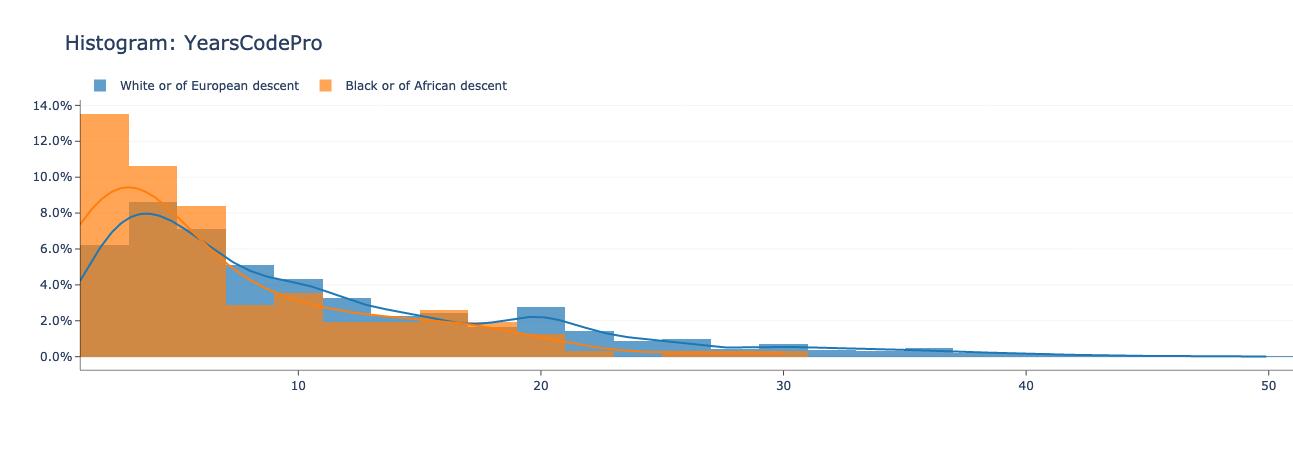

In [144]:
output_kde(data_2019, "YearsCodePro", "Ethnicity", ["White or of European descent", "Black or of African descent"])

In [142]:
data_2019[data_2019["YearsCodePro"] > -1].groupby(["Ethnicity"]).mean()[["YearsCodePro", "YearsCode"]]

,YearsCodePro,YearsCode
Ethnicity,,
Biracial,7.193548,12.258065
Black or of African descent,6.819355,10.954839
East Asian,6.597610,10.872510
Hispanic or Latino/Latina,7.762069,11.717241
Middle Eastern,7.757576,12.893939
Multiracial,10.580000,14.940000
"Native American, Pacific Islander, or Indigenous Australian",7.652174,11.913043
South Asian,6.953216,10.874269
White or of European descent,10.430991,14.803363


In [143]:
data_2019.groupby(["Ethnicity"]).mean()[["Age"]]

,Age
Ethnicity,
Biracial,31.914286
Black or of African descent,31.142012
East Asian,30.623188
Hispanic or Latino/Latina,31.750000
Middle Eastern,30.942029
Multiracial,34.596491
"Native American, Pacific Islander, or Indigenous Australian",31.916667
South Asian,29.972299
White or of European descent,34.276480
